In [66]:
# Import Libraries
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
import matplotlib.pyplot as plt
import seaborn as sns

In [67]:
# Load Data
df = pd.read_csv("players.csv")
print("Data shape:", df.shape)
df.head()

Data shape: (1216, 7)


,Teams,Seasons,Players,Matches,Goals,Assists,Seasons Ratings
0,InterMiami,2024,Lionel Messi,15,14,11,8.5
1,InterMiami,2023,Lionel Messi,14,11,5,8.0
2,PSG,2022/2023,Lionel Messi,41,21,20,8.1
3,PSG,2021/2022,Lionel Messi,34,11,14,7.9
4,Barcelona,2020/2021,Lionel Messi,47,38,12,8.4


In [70]:
# Handle Missing Values
print("Missing values before cleaning:")
print(df.isnull().sum())

# Drop rows with missing target (Season Rating)
df.dropna(subset=['Seasons Ratings'], inplace=True)

# Fill numeric features with median
numeric_cols = ['Matches', 'Goals', 'Assists']
df[numeric_cols] = df[numeric_cols].fillna(df[numeric_cols].median())

print("\nMissing values after cleaning:")
print(df.isnull().sum())

Missing values before cleaning:
Teams              0
Seasons            0
Players            0
Matches            0
Goals              0
Assists            0
Seasons Ratings    0
dtype: int64

Missing values after cleaning:
Teams              0
Seasons            0
Players            0
Matches            0
Goals              0
Assists            0
Seasons Ratings    0
dtype: int64


In [72]:
# Feature Engineering
df['Goals_per_Match'] = df['Goals'] / df['Matches']
df['Assists_per_Match'] = df['Assists'] / df['Matches']
df['Contributions_per_Match'] = (df['Goals'] + df['Assists']) / df['Matches']

# One-hot encode teams (avoid encoding 'Player' to prevent overfitting)
df = pd.get_dummies(df, columns=['Teams'], drop_first=True)
df.head()

,Seasons,Players,Matches,Goals,Assists,Seasons Ratings,Goals_per_Match,Assists_per_Match,Contributions_per_Match,Teams_AL Hilal,...,Teams_Villarreal,Teams_Vitesse,Teams_Vitoria de Guimaraes,Teams_Watford,Teams_West Brom,Teams_West Ham,Teams_Wolfsburg,Teams_Wolves,Teams_Zenit,Teams_real Madrid
0,2024,Lionel Messi,15,14,11,8.5,0.933333,0.733333,1.666667,False,...,False,False,False,False,False,False,False,False,False,False
1,2023,Lionel Messi,14,11,5,8.0,0.785714,0.357143,1.142857,False,...,False,False,False,False,False,False,False,False,False,False
2,2022/2023,Lionel Messi,41,21,20,8.1,0.512195,0.487805,1.000000,False,...,False,False,False,False,False,False,False,False,False,False
3,2021/2022,Lionel Messi,34,11,14,7.9,0.323529,0.411765,0.735294,False,...,False,False,False,False,False,False,False,False,False,False
4,2020/2021,Lionel Messi,47,38,12,8.4,0.808511,0.255319,1.063830,False,...,False,False,False,False,False,False,False,False,False,False


In [74]:
# Define Features & Target
X = df.drop(['Seasons Ratings', 'Players', 'Seasons'], axis=1)  # Drop non-feature columns
y = df['Seasons Ratings']

# Split data (80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
print("Train shape:", X_train.shape, "Test shape:", X_test.shape)

Train shape: (972, 112) Test shape: (244, 112)


In [75]:
# Preprocessing + Scaling
numeric_features = ['Matches', 'Goals', 'Assists', 'Goals_per_Match', 'Assists_per_Match', 'Contributions_per_Match']
categorical_features = list(X_train.columns[X_train.columns.str.startswith('Team_')])  # One-hot encoded teams

preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numeric_features),
        ('cat', 'passthrough', categorical_features)  # One-hot encoded, no scaling
    ])

In [76]:
# XGBoost Model
model = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('regressor', XGBRegressor(
        n_estimators=200,
        max_depth=5,
        learning_rate=0.1,
        random_state=42
    ))
])

model.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num', StandardScaler(),
                                                  ['Matches', 'Goals',
                                                   'Assists', 'Goals_per_Match',
                                                   'Assists_per_Match',
                                                   'Contributions_per_Match']),
                                                 ('cat', 'passthrough', [])])),
                ('regressor',
                 XGBRegressor(base_score=None, booster=None, callbacks=None,
                              colsample_bylevel=None, colsample_bynode=None,
                              colsample_bytree=None, de...
                              feature_types=None, feature_weights=None,
                              gamma=None, grow_policy=None,
                              importance_type=None,
                              interaction_constraints=None, learning_rate=0.1,
                              max_bin=None, max_cat_threshold=None,
                              max_cat_to_onehot=None, max_delta_step=None,
                              max_depth=5, max_leaves=None,
                              min_child_weight=None, missing=nan,
                              monotone_constraints=None, multi_strategy=None,
                              n_estimators=200, n_jobs=None,
                              num_parallel_tree=None, ...))])

Mean Squared Error: 0.11
R² Score: 0.28


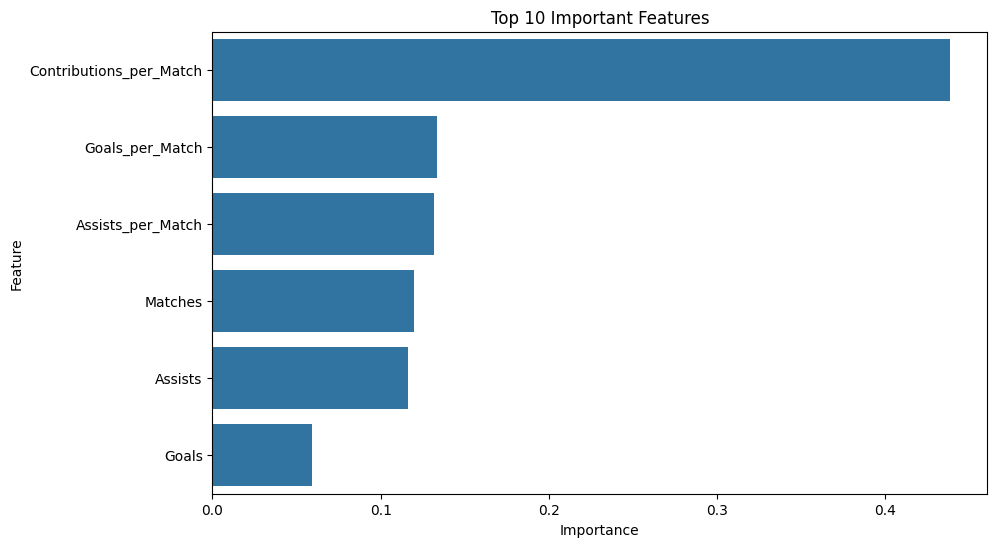

In [77]:
# Predictions & Metrics
y_pred = model.predict(X_test)

mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
print(f"Mean Squared Error: {mse:.2f}")
print(f"R² Score: {r2:.2f}")

# Cell 9: Feature Importance Plot
feature_importances = model.named_steps['regressor'].feature_importances_
features = numeric_features + categorical_features
importance_df = pd.DataFrame({'Feature': features, 'Importance': feature_importances})
importance_df = importance_df.sort_values('Importance', ascending=False)

plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=importance_df.head(10))
plt.title("Top 10 Important Features")
plt.show()

In [80]:
# Cell 10: Optuna Tuning (Run only if needed)
import optuna

def objective(trial):
    params = {
        'n_estimators': trial.suggest_int('n_estimators', 100, 500),
        'max_depth': trial.suggest_int('max_depth', 3, 10),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.2),
        'subsample': trial.suggest_float('subsample', 0.7, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.7, 1.0),
    }
    
    model = Pipeline(steps=[
        ('preprocessor', preprocessor),
        ('regressor', XGBRegressor(**params))
    ])
    
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    return r2_score(y_test, y_pred)

study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=50)
print("Best R²:", study.best_value)
print("Best params:", study.best_params)

/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
[I 2025-04-23 03:55:56,550] A new study created in memory with name: no-name-3fe82092-e638-4cd4-8a0d-8f13efc0f94a
[I 2025-04-23 03:55:56,749] Trial 0 finished with value: 0.344112900576072 and parameters: {'n_estimators': 250, 'max_depth': 4, 'learning_rate': 0.052915340612304955, 'subsample': 0.8348891711347431, 'colsample_bytree': 0.9151550996907483}. Best is trial 0 with value: 0.344112900576072.
[I 2025-04-23 03:55:56,844] Trial 1 finished with value: 0.2820622657378693 and parameters: {'n_estimators': 112, 'max_depth': 5, 'learning_rate': 0.19043405273944577, 'subsample': 0.8686917815836173, 'colsample_bytree': 0.7510770299031915}. Best is trial 0 with value: 0.344112900576072.
[I 2025-04-23 03:55:57,

Best R²: 0.3893873360487685
Best params: {'n_estimators': 436, 'max_depth': 3, 'learning_rate': 0.010946976303969574, 'subsample': 0.7816544027502101, 'colsample_bytree': 0.8033503761320024}


In [86]:
from joblib import load
import pandas as pd

# Load your trained model
model = load('player_performance_predictor.joblib')  # Make sure the file path is correct

In [109]:
import numpy as np

def predict_player_future(player_name, dataset, seasons=3, current_age=30):
    player_data = dataset[dataset['Players'] == player_name]
    if player_data.empty:
        raise ValueError(f"Player '{player_name}' not found.")
    
    latest_season = player_data.sort_values('Seasons').iloc[-1].copy()
    
    # Extract base year (handles '2024' or '2023/2024')
    if '/' in str(latest_season['Seasons']):
        latest_year = int(str(latest_season['Seasons']).split('/')[-1])
    else:
        latest_year = int(latest_season['Seasons'])
    
    predictions = []
    current_goals = latest_season['Goals']
    current_assists = latest_season['Assists']
    current_matches = latest_season['Matches']
    
    for year in range(1, seasons + 1):
        # --- Simulate Realistic Variance ---
        # 1. Random fluctuation (±10% stats)
        goals_change = np.random.uniform(0.9, 1.1)  # Random growth/decline
        assists_change = np.random.uniform(0.9, 1.1)
        matches_change = np.random.uniform(0.95, 1.05)
        
        # 2. Age-based decline (accelerates after 30)
        age = current_age + year
        if age > 30:
            age_penalty = 1.0 - (age - 30) * 0.03  # 3% annual decline after 30
            goals_change *= age_penalty
            assists_change *= age_penalty
        
        # Update stats
        current_matches = int(current_matches * matches_change)
        current_goals = int(current_goals * goals_change)
        current_assists = int(current_assists * assists_change)
        
        # Ensure stats don't drop below 0
        current_matches = max(current_matches, 5)
        current_goals = max(current_goals, 0)
        current_assists = max(current_assists, 0)
        
        # --- Calculate Features ---
        goals_per_match = current_goals / current_matches if current_matches > 0 else 0
        assists_per_match = current_assists / current_matches if current_matches > 0 else 0
        contributions_per_match = (current_goals + current_assists) / current_matches if current_matches > 0 else 0
        
        # --- Predict Rating ---
        features = pd.DataFrame([{
            'Matches': current_matches,
            'Goals': current_goals,
            'Assists': current_assists,
            'Goals_per_Match': goals_per_match,
            'Assists_per_Match': assists_per_match,
            'Contributions_per_Match': contributions_per_match
        }])
        
        projected_rating = model.predict(features)[0]
        
        predictions.append({
            'Player': player_name,
            'Season': f"{latest_year + year}",
            'Predicted Rating': round(projected_rating, 2),
            'Goals': current_goals,
            'Assists': current_assists,
            'Matches': current_matches,
            'Age': age
        })
    
    return pd.DataFrame(predictions)

In [113]:
# Load your dataset
df = pd.read_csv('players.csv')

# Predict for a player (e.g., "Lionel Messi")
future_performance = predict_player_future("Harry Kane", df, seasons=3)
print(future_performance)

       Player Season  Predicted Rating  Goals  Assists  Matches  Age
0  Harry Kane   2025              7.96     42       12       46   31
1  Harry Kane   2026              7.87     42       11       45   32
2  Harry Kane   2027              7.90     41        9       45   33
